COMP5930M Scientific Computation - Tutorial 9  \\
Iterative linear solvers

To illustrate the performance of linear algebra algorithms for large linear systems, we experiment with three different linear problems from Matrix Market (https://math.nist.gov/MatrixMarket/). If using Google Colab, you need to upload the three .mtx files to your local session storage.

Matrix 1: Structural engineering problem of a frame within a suspension bridge

Matrix 2: 3D model of an oil reservoir

Matrix 3: Lid-driven cavity flow in a box

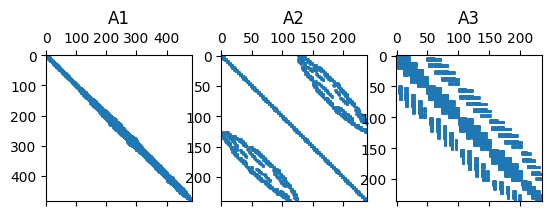

In [204]:
from scipy.io import mmread
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import time

A1 = mmread('bcsstk20.mtx')
A2 = mmread('steam1.mtx')
A3 = mmread('e05r0100.mtx')

A1 = A1.tocsr()
A2 = A2.tocsr()
A3 = A3.tocsr()

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A1, markersize=1)
ax1.set_title('A1')
ax2.spy(A2, markersize=1)
ax2.set_title('A2')
ax3.spy(A3, markersize=1)
ax3.set_title('A3')

plt.show()

By plotting the sparsity patterns of the three matrices, we can observe they are all sparse but have very different sparsity patterns. $A_1$ is mostly diagonal, whereas $A_2$ has many elements away from the diagonal due to the 3D discretisation, and $A_3$ has many more nonzero elements in a block pattern (typical for higher-order spatial discretisation methods). This will have implications to the efficiency of matrix factorisations.

We will make use of the scipy.sparse.linalg.splu method for sparse LU-factorisation (provided by the SuperLU library, https://portal.nersc.gov/project/sparse/superlu/).

Let's start with simple iterations: Jacobi and Gauss-Seidel:

In [205]:
def jacobi(A, b, tol, maxiter):
  # Extract the splitting A = D + E
  d = A.diagonal()
  D = sp.sparse.spdiags(d, 0, A.shape[0], A.shape[1])
  D = D.tocsr()
  E = A - D

  x = sp.sparse.csc_array( (A.shape[1],1), dtype=np.float64)

  # Perform Jacobi iteration
  r = sp.sparse.linalg.norm(b - A @ x)
  k = 0

  print(' k    rk')

  while (r > tol and k < maxiter):
    k += 1

    # Iteration with the equation D x{k+1} = b - E x_k
    x = np.atleast_2d(sp.sparse.linalg.spsolve(D, b - E @ x))
    x = x.T

    # Update the residual norm
    r = np.linalg.norm(b - A @ x)

    print('{0:2.0f}  {1:2.2e}'.format(k, r))

  if (k == maxiter):
    print('Convergence failed')

In [206]:
def gaussSeidel(A, b, tol, maxiter):
  # Extract the splitting A = D + E
  d = A.diagonal()
  D = sp.sparse.triu(A)
  D = D.tocsr()
  E = A - D

  x = sp.sparse.csc_array( (A.shape[1],1), dtype=np.float64)

  # Perform Jacobi iteration
  r = sp.sparse.linalg.norm(b - A @ x)
  k = 0

  print(' k    rk')

  while (r > tol and k < maxiter):
    k += 1

    # Iteration with the equation D x{k+1} = b - E x_k
    x = np.atleast_2d(sp.sparse.linalg.spsolve(D, b - E @ x))
    x = x.T

    # Update the residual norm
    r = np.linalg.norm(b - A @ x)

    print('{0:2.0f}  {1:2.2e}'.format(k, r))

  if (k == maxiter):
    print('Convergence failed')

Let us test the Jacobi iteration with a small example. The matrix
$$
A=\begin{bmatrix}
    14 &    0  &   5  &   2  &   1 \\
     0 &    8  &  -3  &   1  &  -2 \\
     5 &   -3  & 12   &  2   &  5  \\
     2 &    1  &   2  &   6  &   1 \\
     1 &   -2  &   5  &   1  &   8
\end{bmatrix}
$$
is symmetric, positive definite but not strictly diagonally dominant.

In [207]:
A = np.array([[14,0,5,2,1],[0,8,-3,1,-2],[5,3,12,2,5],[2,1,2,6,1],[1,-2,5,1,8]])
A = sp.sparse.csr_matrix(A)

b = sp.sparse.lil_array((A.shape[0], 1), dtype=np.float64)
b[0] = 1
b = b.tocsc()

jacobi(A, b, 1e-6, 100)

 k    rk
 1  3.91e-01
 2  3.03e-01
 3  2.24e-01
 4  1.79e-01
 5  1.38e-01
 6  1.09e-01
 7  8.52e-02
 8  6.74e-02
 9  5.28e-02
10  4.17e-02
11  3.28e-02
12  2.58e-02
13  2.03e-02
14  1.60e-02
15  1.26e-02
16  9.93e-03
17  7.81e-03
18  6.15e-03
19  4.84e-03
20  3.81e-03
21  3.00e-03
22  2.36e-03
23  1.86e-03
24  1.47e-03
25  1.15e-03
26  9.08e-04
27  7.15e-04
28  5.63e-04
29  4.43e-04
30  3.49e-04
31  2.75e-04
32  2.16e-04
33  1.70e-04
34  1.34e-04
35  1.06e-04
36  8.32e-05
37  6.55e-05
38  5.16e-05
39  4.06e-05
40  3.20e-05
41  2.52e-05
42  1.98e-05
43  1.56e-05
44  1.23e-05
45  9.67e-06
46  7.61e-06
47  5.99e-06
48  4.72e-06
49  3.72e-06
50  2.93e-06
51  2.30e-06
52  1.81e-06
53  1.43e-06
54  1.12e-06
55  8.85e-07


Jacobi converges in 55 iterations despite the fact that the matrix is not strictly diagonally dominant. Now we try the Gauss-Seidel iteration:

In [208]:
gaussSeidel(A, b, 1e-6, 100)

 k    rk
 1  3.91e-01
 2  1.16e-01
 3  4.29e-02
 4  1.40e-02
 5  4.33e-03
 6  1.31e-03
 7  3.93e-04
 8  1.17e-04
 9  3.47e-05
10  1.03e-05
11  3.05e-06
12  9.05e-07


In comparison, Gauss-Seidel only requires 12 iterations.

When we attempt to solve the challenging real-life problems, we observe that Gauss-Seidel convergence is very slow:

In [209]:
b1= sp.sparse.lil_array((A1.shape[0], 1), dtype=np.float64)
b1[0] = 1
b1 = b1.tocsc()

b2 = sp.sparse.lil_array((A2.shape[0], 1), dtype=np.float64)
b2[0] = 1
b2 = b2.tocsc()

b3 = sp.sparse.lil_array((A3.shape[0], 1), dtype=np.float64)
b3[0] = 1
b3 = b3.tocsc()

gaussSeidel(A1, b1, 1e-6, 100)
gaussSeidel(A2, b2, 1e-6, 100)
gaussSeidel(A3, b3, 1e-6, 100)

 k    rk
 1  1.25e+02
 2  1.38e+02
 3  1.33e+02
 4  1.28e+02
 5  1.24e+02
 6  1.21e+02
 7  1.17e+02
 8  1.15e+02
 9  1.12e+02
10  1.09e+02
11  1.07e+02
12  1.05e+02
13  1.03e+02
14  1.02e+02
15  9.99e+01
16  9.83e+01
17  9.69e+01
18  9.55e+01
19  9.42e+01
20  9.29e+01
21  9.18e+01
22  9.07e+01
23  8.96e+01
24  8.86e+01
25  8.76e+01
26  8.67e+01
27  8.58e+01
28  8.50e+01
29  8.42e+01
30  8.34e+01
31  8.26e+01
32  8.19e+01
33  8.12e+01
34  8.06e+01
35  7.99e+01
36  7.93e+01
37  7.87e+01
38  7.81e+01
39  7.75e+01
40  7.70e+01
41  7.65e+01
42  7.59e+01
43  7.55e+01
44  7.50e+01
45  7.45e+01
46  7.40e+01
47  7.36e+01
48  7.32e+01
49  7.27e+01
50  7.23e+01
51  7.19e+01
52  7.15e+01
53  7.11e+01
54  7.08e+01
55  7.04e+01
56  7.00e+01
57  6.97e+01
58  6.94e+01
59  6.90e+01
60  6.87e+01
61  6.84e+01
62  6.81e+01
63  6.78e+01
64  6.75e+01
65  6.72e+01
66  6.69e+01
67  6.66e+01
68  6.63e+01
69  6.61e+01
70  6.58e+01
71  6.55e+01
72  6.53e+01
73  6.50e+01
74  6.48e+01
75  6.45e+01
76  6.43e+01
77 

/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:293: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


We will now use Conjugate Gradient to solve the problems $A1$, $A2$ and $A3$:

In [210]:
x1, info1 = sp.sparse.linalg.cg(A1,b1.todense())
print(info1)

x2, info2 = sp.sparse.linalg.cg(A2,b2.todense())
print(info2)

x3, info3 = sp.sparse.linalg.cg(A3,b3.todense())
print(info3)

4850
0
2360


The return value is 0 if the algorithm converged, and >0 then the algorithm didn't converge after that many iterations. Therefore we can see that afer 4850 iterations no solution was achieved for $A_1$, for $A_2$ the problem converged, and again no solution was found for $A_3$. This is the typical behaviour of CG without a preconditioner.

Now let's use the incomplete LU preconditioner for these problems:

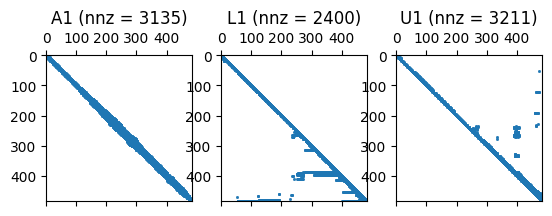

In [211]:
# We compute the incomplete LU factors using numerical
drop_tol = 5e-7
ILU1 = sp.sparse.linalg.spilu(A1,drop_tol)

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A1, markersize=1)
ax1.set_title('A1 (nnz = ' + str(A1.getnnz()) + ')')
ax2.spy(ILU1.L, markersize=1)
ax2.set_title('L1 (nnz = ' + str(ILU1.L.getnnz()) + ')')
ax3.spy(ILU1.U, markersize=1)
ax3.set_title('U1 (nnz = ' + str(ILU1.U.getnnz()) + ')')

plt.show()

We control the sparsity of the incomplete LU factors with the parameter drop_tol. The higher it is, the sparser the factors.

To use the preconditioner, we need to create a LinearOperator that is called by CG to solve the preconditioning step $Mz=r$ using $M=\bar{L}\bar{U}$ as the preconditioner:

In [212]:
# We define a LinearOperator that uses the incomplete sparse LU to solve the
# preconditioning step Mz = r
M1 = sp.sparse.linalg.LinearOperator((A1.shape[0],A1.shape[1]), ILU1.solve)

iters = 0

def iteration_count(arr):
  global iters
  iters += 1

# Now the preconditioner M can be passed to CG
x1, info1 = sp.sparse.linalg.cg(A1, b1.todense(), M=M1, callback=iteration_count)
print(iters)

20


The preconditioned CG now converges in 20 iterations. We can observe the following phenomena:

i) If we increase drop_tol, the number of iterations increases and either CG no longer converges or the factors $L$,$U$ become singular.

ii) If we decrease drop_tol, the number of iterations decreses, the factors get closer to the true factors $L$,$U$, and eventually CG converges in 1 iteration.

Let's try next the example $A_2$:

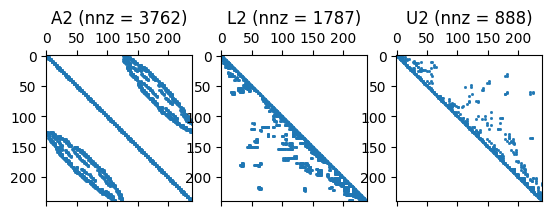

In [213]:
# We compute the incomplete LU factors using numerical
drop_tol = 5e-2
ILU2 = sp.sparse.linalg.spilu(A2,drop_tol)

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A2, markersize=1)
ax1.set_title('A2 (nnz = ' + str(A2.getnnz()) + ')')
ax2.spy(ILU2.L, markersize=1)
ax2.set_title('L2 (nnz = ' + str(ILU2.L.getnnz()) + ')')
ax3.spy(ILU2.U, markersize=1)
ax3.set_title('U2 (nnz = ' + str(ILU2.U.getnnz()) + ')')

plt.show()

In [214]:
# We define a LinearOperator that uses the incomplete sparse LU to solve the
# preconditioning step Mz = r
M2 = sp.sparse.linalg.LinearOperator((A2.shape[0],A2.shape[1]), ILU2.solve)

iters = 0

# Now the preconditioner M can be passed to CG
x2, info2 = sp.sparse.linalg.cg(A2, b2.todense(), M=M2, callback=iteration_count)
print(iters)

1


In this case, the incomplete LU factorisation turns out to be almost exactly the same as the true LU factorisation, which results in the CG algorithm converging in 1 iteration.

Finally, let's try $A_3$:

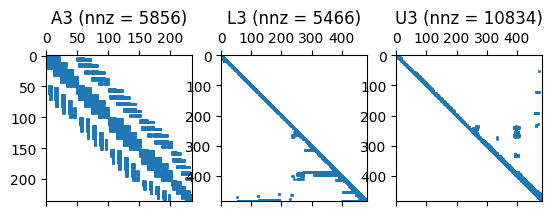

In [215]:
# We compute the incomplete LU factors using numerical
drop_tol = 1e-3
ILU3 = sp.sparse.linalg.spilu(A3,drop_tol)

fig, axs = plt.subplots(1, 3)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]

ax1.spy(A3, markersize=1)
ax1.set_title('A3 (nnz = ' + str(A3.getnnz()) + ')')
ax2.spy(ILU1.L, markersize=1)
ax2.set_title('L3 (nnz = ' + str(ILU3.L.getnnz()) + ')')
ax3.spy(ILU1.U, markersize=1)
ax3.set_title('U3 (nnz = ' + str(ILU3.U.getnnz()) + ')')

plt.show()

In [216]:
# We define a LinearOperator that uses the incomplete sparse LU to solve the
# preconditioning step Mz = r
M3 = sp.sparse.linalg.LinearOperator((A3.shape[0],A3.shape[1]), ILU3.solve)

iters = 0

# Now the preconditioner M can be passed to CG
x3, info3 = sp.sparse.linalg.cg(A3, b3.todense(), M=M3, callback=iteration_count)
print(iters)

10


CG now converges in 10 iterations, even if the incomplete factors are quite dense.